In [1]:
#Import packages and libraries

#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import math
import os.path
from PIL import Image

#Finance
import yfinance as yf

#Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model

#Twitter and NLP
import tweepy 
import preprocessor as preprocess 
import re
from textblob import TextBlob
import nltk
nltk.download('punkt')

#Streamlit
import streamlit as st
from plotly import graph_objs as go

#Pickle
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\proprio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
#Twitter API Keys
consumer_key= 'r4G4jn1kjUiMCSzr7rpmyz1Yv'
consumer_secret= 'i4sAmLzvethIHISYWUu8gricaQ7F2uyw7LitKOihFo1KTidFt5'
access_token='1505192442605314057-Ehu1ltCoGVlpRQhnmktFV6IGvKP6Ti'
access_token_secret='5FCsWKq2WZ2ZMQLt9MOF1OXYqvchdwqYb67DmgGFGDbRP'

In [4]:
#Data fetch function
def get_quote(ticker):
    """
    Function to check if our ticker CSV exists. If not, it will get to get our stock ticker data via Yahoo Finance API
    It will filter into a panda.Dataframe with the relevant informations and store into a CSV file.
    It will then return the CSV file path and the ticker's company name
    """
    
    info_filename = info_filename = 'tickerinfo/'+ ticker + str(date.today()) +'.csv'
    ticker_name = yf.Ticker(ticker).info['shortName']
    
    #Detect if a model file is present
    if (os.path.exists(info_filename) == False):
        end = date.today()
        start = end - datetime.timedelta(days=2 * 365)
        data = yf.download(ticker, start=start, end=end)
        df = pd.DataFrame(data = data)
        df.to_csv(info_filename)
        
    return info_filename, ticker_name

In [5]:
#Price prediction algorithm function
def predict_price(df, ticker):
    """
    Function which will analyze the chosen ticker and its DataFrame as inputs.
    It will return the next day's predicted price and the RMSE error between
    the real and predicted values by the model as the file path for
    image file of the real vs predicted price plot
    """
    #Split data into training set and test dataset
    train_ds = df.iloc[0:int(0.8*len(df)),:]
    test_ds = df.iloc[int(0.8*len(df)):,:]
    
    prediction_days = 7

    training_set=df.iloc[:,4:5].values

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = scaler.fit_transform(training_set)

    x_train=[]
    y_train=[]
    
    for i in range(prediction_days,len(training_set_scaled)):
        x_train.append(training_set_scaled[i-prediction_days:i,0])
        y_train.append(training_set_scaled[i,0])
        
    #Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    X_forecast = np.array(x_train[-1,1:])
    X_forecast = np.append(X_forecast,y_train[-1])
    
    #Reshaping: Adding 3rd dimension
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))#.shape 0=row,1=col
    X_forecast = np.reshape(X_forecast, (1,X_forecast.shape[0],1))

    filename = 'modelh5/' + str(ticker)+'_model.h5'
    
    #Detect if a model file is present
    if (os.path.exists(filename)):
        model = load_model(filename)
    else:
    
        #Initialise RNN
        model = Sequential()

        #Add first LSTM layer
        model.add(LSTM(units = 50,return_sequences=True,input_shape=(x_train.shape[1],1)))
        model.add(Dropout(0.3))

        model.add(LSTM(units = 75,return_sequences=True))
        model.add(Dropout(0.4))

        model.add(LSTM(units = 100,return_sequences=True))
        model.add(Dropout(0.5))

        model.add(LSTM(units = 125))
        model.add(Dropout(0.6))

        model.add(Dense(units = 1))

        #Compile
        model.compile(optimizer='adam',loss='mean_squared_error')

        #Training
        model.fit(x_train, y_train, epochs = 50, batch_size = 32 )
        
        #Saving model for this specific ticker
        model.save(filename)

    #Testing
    y = test_ds.iloc[:,4:5].values

    #Combining training and testing set and using the number of prediction days before the test set
    total_ds = pd.concat((train_ds['Close'],test_ds['Close']),axis=0) 
    testing_set = total_ds[ len(total_ds) -len(test_ds) - prediction_days: ].values
    testing_set = testing_set.reshape(-1,1)

    #Scaling
    testing_set = scaler.transform(testing_set)

    #Create testing data structure
    x_test=[]
    
    for i in range(prediction_days,len(testing_set)):
        x_test.append(testing_set[i-prediction_days:i,0])
    
    #Convert to numpy arrays
    x_test=np.array(x_test)

    #Reshaping: Adding 3rd dimension
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    #Testing Prediction
    y_test = model.predict(x_test)

    #Getting original prices back from scaled values
    y_test = scaler.inverse_transform(y_test)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    plt.plot(y,label='Actual Price')  
    plt.plot(y_test,label='Predicted Price')

    plt.legend(loc=4)
    RNN_filename = ('RNNplots/' + str(ticker) + ' ' + str(date.today())  +' RNN model.png')
    plt.savefig(RNN_filename)
    plt.close(fig)

    rmse = math.sqrt(mean_squared_error(y, y_test))

    #Forecasting Prediction
    y_pred = model.predict(X_forecast)

    #Getting original prices back from scaled values
    y_pred = scaler.inverse_transform(y_pred)

    nextday_price = y_pred[0,0]

    print("Tomorrow's ",ticker," Closing Price Prediction by LSTM: ", nextday_price)
    print("LSTM RMSE:", rmse)
    return nextday_price, rmse, RNN_filename

In [6]:
#Twitter sentiment analysis
def analyze_tweet_sentiment(ticker):
    """
    Function which will search through twitter for the requested ticker and
    analyze the overall sentiment if positive or negative.
    It will return the overall sentiment score, the overall verdict, number of positive tweets,
    number of negative tweets and number of neutral tweets, a list of tweets and its polarities,
    the file path for the sentiment analysis pie chart image
    """
    #Find the company name associated to the ticker via yfinance
    name = yf.Ticker(ticker).info['shortName']
    
    #Accessing and authenticating Twitter
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth, wait_on_rate_limit = True)
    
    #Number of tweets to analyze
    n_tweets = 300
    
    #Search twitter
    tweets = tweepy.Cursor(user.search_tweets, q=name,
                           tweet_mode='extended', lang='en').items(n_tweets)

    tweet_list = [] #List of tweets
    polarity_list =[] #List of polarities of the tweets
    overall_polarity = 0

    #Count positive and negative tweets
    positive_tweets = 0
    negative_tweets = 0
    
    for tw in tweets:

        #Convert to Textblob format for assigning polarity
        tweet = tw.full_text
        
        #Clean
        tweet = preprocess.clean(tweet)
        tweet = re.sub('&amp;','&',tweet) #replace &amp by '&'
        tweet = re.sub(':','',tweet)#Remove :
        tweet = tweet.encode('ascii', 'ignore').decode('ascii') #Remove nonascii characters

        tweet_list.append(tweet) #populate our tweet list
        
        blob = TextBlob(tweet)
        tweet_polarity = 0 #Polarity for each tweet
        
        #Analyze each sentence in the tweet
        for sentence in blob.sentences:
            tweet_polarity += sentence.sentiment.polarity
            
            #Increment the count whether it is positive or negative
            if tweet_polarity > 0:
                positive_tweets += 1
                
            if tweet_polarity < 0:
                negative_tweets += 1

            overall_polarity += sentence.sentiment.polarity #Populate our polarity list
        
        polarity_list.append(tweet_polarity)

    if len(tweet_list) != 0:
        overall_polarity = overall_polarity / len(tweet_list)
    else:
        overall_polarity = overall_polarity
        
    neutral_tweets = n_tweets - (positive_tweets + negative_tweets)
    
    if neutral_tweets < 0:
        negative_tweets = negative_tweets + neutral_tweets
        

    print("Positive Tweets :", positive_tweets, "Negative Tweets :", negative_tweets,
          "Neutral Tweets :", neutral_tweets)
    
    #Drawing a pie chart
    labels=['Positive','Negative','Neutral']
    colors = ['tab:green', 'tab:red' , 'tab:orange']
    sizes = [positive_tweets, negative_tweets, neutral_tweets]
    explode = (0, 0, 0)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    
    SA_filename = 'SApiecharts/'+ str(ticker) +' '+ str(date.today()) +' Twitter Sentiment Analysis.png'
    
    #Save the pie chart 
    plt.savefig(SA_filename)
    
    plt.close(fig)

    #plt.show()
    if overall_polarity > 0:
        polarity_verdict = 'Overall Positive'
    else:
        polarity_verdict = 'Overall Negative'
        
    return overall_polarity, polarity_verdict, positive_tweets, negative_tweets, neutral_tweets, tweet_list, polarity_list ,SA_filename

In [7]:
def recommend_action(polarity, info_ticker, price_nextday):
    if info_ticker.iloc[-1]['Close'] < price_nextday:
        if polarity > 0:
            decision = 'Good sentiment and rising. Seems like a good idea to buy.'
        elif polarity <= 0:
            decision = "Bad sentiment and rising. Might wait before buying or sell some existing stock."
    elif info_ticker.iloc[-1]['Close'] > price_nextday:
        if polarity > 0:
            decision= 'Good sentiment and falling. Might wait before buying.'
        elif polarity <= 0:
            decision= 'Bad sentiment and falling. Seems like a good idea to sell.'  
    
    return decision

In [8]:
#Main execution
ticker = 'AAPL'
csv_path, ticker_name = get_quote(ticker)

In [9]:
df = pd.read_csv(csv_path)
info_stock = df.iloc[-1:]
display(info_stock)
df = df.dropna()

,Date,Open,High,Low,Close,Adj Close,Volume
504,2022-04-20,168.759995,168.880005,166.100006,167.229996,167.229996,67828800


In [10]:
price_nextday, rmse, RNN_filename = predict_price(df, ticker)

Epoch 1/50
16/16 [==============================] - 12s 37ms/step - loss: 0.1578
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0366
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0248
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0159
Epoch 5/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0119
Epoch 6/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0109
Epoch 7/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0094
Epoch 8/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0101
Epoch 9/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0101
Epoch 10/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0106
Epoch 11/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0097
Epoch 12/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0109
Epoch 13/50
16/16 [=================

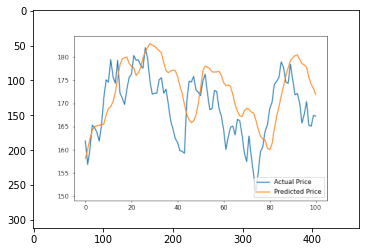

In [11]:
#Display real vs predicted price by the model past 100 days
image_RNN = Image.open(RNN_filename)
plt.imshow(image_RNN)
plt.show()

Positive Tweets : 162 Negative Tweets : 30 Neutral Tweets : 108


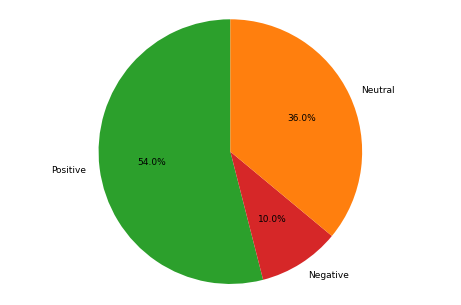

In [12]:
polarity, polarity_verdict, positive, negative, neutral,tweet_list, polarity_list, SA_filename = analyze_tweet_sentiment(ticker)

In [13]:
tweet_df = pd.DataFrame(list(zip(tweet_list, polarity_list)), columns = ['Tweet', 'Polarity'])

In [14]:
decision = recommend_action(polarity, info_stock, price_nextday)
print(decision)

Good sentiment and rising. Seems like a good idea to buy.


References

Machine Learning to Predict Stock Prices:
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233 

Twitter Sentiment Analysis using Python
https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/ 

Streamlit 101: An in-depth introduction:
https://towardsdatascience.com/streamlit-101-an-in-depth-introduction-fc8aad9492f2 